<a href="https://colab.research.google.com/github/Kaiziferr/deep_learning/blob/master/multilayer_perceptron/01_neural_network_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense

from tensorflow.keras.metrics import Recall

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import metrics

# **Objetivo**
---
El objetivo del conjunto de datos es predecir de forma diagnóstica si un paciente mujer tiene o no diabetes.

## **Dicionario de datos**
---
- `Pregnancies` : número de veces de embarazo
- `Glucose` : concentración de glucosa plasmática a las 2 horas en una prueba de tolerancia oral a la glucosa
- `BloodPressure`: presión arterial diastólica (mm Hg)
- `SkinThickness`: grosor del pliegue cutáneo del tríceps (mm)
- `Insulin` : insulina sérica de 2 horas (mu U/ml)
- `BMI` : Índice de masa corporal (peso en kg/(altura en m)^2)
- `DiabetesPedigreeFunction`: función de pedigrí de diabetes
- `Age`: edad
- `Outcome`: churm

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/Kaiziferr/datasets/main/diabetes.csv')
data_values = data.values

In [ ]:
data.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


# **Data Split**
---

In [ ]:
X = data_values[:, :8]
y = data_values[:, 8]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, shuffle=True)

In [ ]:
def plot_bars(data: np.ndarray, title: str= 'feature', x_size:int=6, y_size:int=4, font_size:int=15, x_label:str='churm',y_label:str='count')->None:
  fig, ax = plt.subplots(figsize = (x_size, y_size))
  fig.suptitle(f'Count plot {title}', fontsize = font_size)
  sns.countplot(x = data, ax = ax)
  _, data_target = np.unique(data, return_counts=True)
  len_data = data.shape[0]
  pe = '{0:.2f}'.format(data_target[1]/len_data)
  ps = '{0:.2f}'.format(data_target[0]/len_data)
  ax.set_xticklabels([f'health \n {ps}', f'sick\n{pe}'])
  ax.set(xlabel=x_label, ylabel=y_label)
  fig.show()

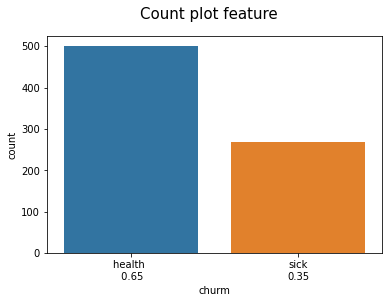

In [ ]:
plot_bars(y)

- Hay un desbalance en el conjunto de datos del 65% para los pacientes sanos y 35% para los pacientes enfermos.


# **Model**
---

In [ ]:
def model_base():
  model = Sequential()
  model.add(Dense(12, input_dim=8, activation='relu', kernel_initializer='glorot_uniform'))
  model.add(Dense(8, activation='relu', kernel_initializer='glorot_uniform'))
  model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Recall(), 'accuracy'])
  return model

In [ ]:
model = model_base()
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=300, batch_size=16, verbose=0)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                108       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history.history.keys()

dict_keys(['loss', 'recall', 'accuracy', 'val_loss', 'val_recall', 'val_accuracy'])

In [ ]:
# Problema de ajuste
loss, accuracy, recall = model.evaluate(X_train, y_train)
print('Recall: %.3f' % recall)
print('Accuracy: %.3f' % accuracy)
print('Loss: %.3f' % loss)

20/20 [==============================] - 0s 1ms/step - loss: 0.4606 - recall: 0.5822 - accuracy: 0.7752
Recall: 0.775
Accuracy: 0.582
Loss: 0.461


- El modelo tiene una sensibilidad del 78% de probabilidades de tener exito en la detección de diabetes
- La precisión no la considero por el desbalance del modelo
- La perdida no es minima

In [ ]:
# Problema de Generalización
loss, accuracy, recall = model.evaluate(X_test, y_test)
print('Recall: %.3f' % recall)
print('Accuracy: %.3f' % accuracy)
print('Loss: %.3f' % loss)

5/5 [==============================] - 0s 3ms/step - loss: 0.5151 - recall: 0.5818 - accuracy: 0.7597
Recall: 0.760
Accuracy: 0.582
Loss: 0.515


- El modelo tiene una sensibilidad del 76% de probabilidades de tener exito en la detección de diabetes
- Una perdida del 52% de que el modelo se equivoque en la predicción

# **Curva de aprendizaje**
---

## **Curvas de aprendizaje de optimización**
---



In [ ]:
def optimization_learning_curves(history: keras.callbacks.History, metrica, title: str= '', x_size:int=8, y_size:int=4, font_size:int=15, x_label:str='Epoch',y_label:str='Loss')->None:
  fig, ax = plt.subplots(figsize = (x_size, y_size))
  fig.suptitle(title, fontsize = font_size)
  ax.plot(history.history[metrica])
  ax.plot(history.history[f'val_{metrica}'])
  ax.set_xlabel(x_label, size = 12)
  ax.set_ylabel(y_label, size = 12)
  ax.legend(['Train', 'Test'], loc = 'upper left', fontsize = 12)
  ax.tick_params(labelsize = 12)
  fig.show()

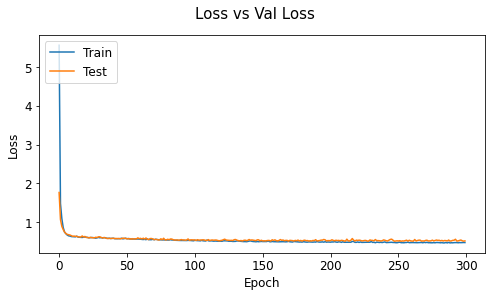

In [ ]:
optimization_learning_curves(history, metrica='loss', title='Loss vs Val Loss')

- La perdida de entrenamiento y validación disminuyen hasta el punto de estabilida durante 300 epocas, con una `brecha de generailización` casi inperceptible.
- Los datos de entrenamiento y validación son representativos

## **Curvas de aprendizaje de rendimiento**
---

In [ ]:
history.history.keys()

dict_keys(['loss', 'recall', 'accuracy', 'val_loss', 'val_recall', 'val_accuracy'])

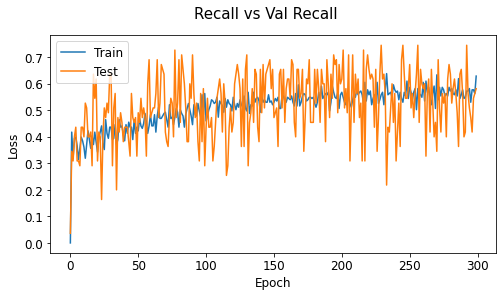

In [ ]:
optimization_learning_curves(history, metrica='recall', title='Recall vs Val Recall')

- Acorde al rendimiento de la sensibilidad los datos de validación no son representativos por la cantidad de ruido. Posiblemente a una configuración de los datos inesperada. Esto no concuerda con los datos de la evaluación del modelo con los datos de validación, puesto se optenia un buen rendimiento de generalización.

- También existe la posibilidad de que el error sea por una mala configuración en la metrica. `Estoy en proceso de aprendizaje`

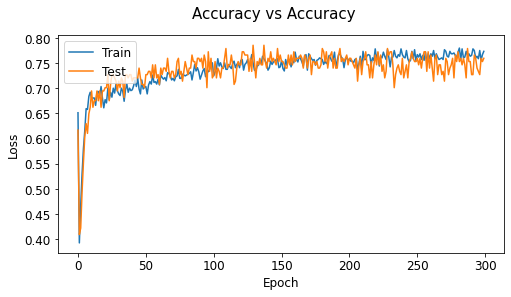

In [ ]:
optimization_learning_curves(history, metrica='accuracy', title='Accuracy vs Accuracy')

Acorde al rendimiento de la accuracy los datos de validación el modelo tiene una convergencia, pero esto puede ser engañoso debido a que el modelo pudo aprender más de los datos de entrenamiento, pese a la brecha.

# **Predictions**
---

In [ ]:
y_pred = (model.predict(X_test)>0.5).astype('int32')
y_pred = np.reshape(y_pred, y_pred.shape[0])
y_pred

array([0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1],
      dtype=int32)

In [ ]:
for i in range(15):
  print('%s --> %d (real %d)'% (X_test[i].tolist(), y_pred[i], y_test[i]))

[0.0, 113.0, 80.0, 16.0, 0.0, 31.0, 0.874, 21.0] --> 0 (real 0)
[3.0, 180.0, 64.0, 25.0, 70.0, 34.0, 0.271, 26.0] --> 1 (real 0)
[7.0, 114.0, 64.0, 0.0, 0.0, 27.4, 0.732, 34.0] --> 0 (real 1)
[1.0, 125.0, 50.0, 40.0, 167.0, 33.3, 0.962, 28.0] --> 1 (real 1)
[2.0, 120.0, 76.0, 37.0, 105.0, 39.7, 0.215, 29.0] --> 0 (real 0)
[2.0, 128.0, 64.0, 42.0, 0.0, 40.0, 1.101, 24.0] --> 1 (real 0)
[4.0, 137.0, 84.0, 0.0, 0.0, 31.2, 0.252, 30.0] --> 1 (real 0)
[3.0, 103.0, 72.0, 30.0, 152.0, 27.6, 0.73, 27.0] --> 0 (real 0)
[6.0, 190.0, 92.0, 0.0, 0.0, 35.5, 0.278, 66.0] --> 1 (real 1)
[1.0, 109.0, 56.0, 21.0, 135.0, 25.2, 0.833, 23.0] --> 0 (real 0)
[1.0, 181.0, 78.0, 42.0, 293.0, 40.0, 1.258, 22.0] --> 0 (real 1)
[0.0, 120.0, 74.0, 18.0, 63.0, 30.5, 0.285, 26.0] --> 0 (real 0)
[7.0, 136.0, 90.0, 0.0, 0.0, 29.9, 0.21, 50.0] --> 0 (real 0)
[1.0, 71.0, 62.0, 0.0, 0.0, 21.8, 0.416, 26.0] --> 0 (real 0)
[3.0, 111.0, 90.0, 12.0, 78.0, 28.4, 0.495, 29.0] --> 0 (real 0)


In [ ]:
# Sesgo predictivo
#sesgo predicción = promedio de predicciones - promedio de etiquetas (observaciones) en el conjunto de datos
# Sick
def sesgo_prediction(prediction:np.ndarray, validation:np.ndarray)->tuple:
  average_prediction = (len(prediction[prediction==1])/len(prediction))
  average_label_target = (len(validation[validation==1]) / len(validation)) 
  sesgo_prediction = average_prediction - average_label_target
  return sesgo_prediction, average_prediction, average_label_target

In [ ]:
sesgo, promedio_prediccion, promedio_validacion = sesgo_prediction(y_pred, y_test)
print(f'Promedio de predicciones:  {promedio_prediccion}')
print(f'Promedio de etiquetas: {promedio_validacion}')
print(f'Sesgo de predicción: {sesgo}')

Promedio de predicciones:  0.2987012987012987
Promedio de etiquetas: 0.35714285714285715
Sesgo de predicción: -0.05844155844155846


- Tiene un sesgo negativo del 5%, el modelo subestima, tiene un porcentaje de errores de no predicciones de pacientes con diabetes

In [ ]:
def consufion_matrix(validation: np.ndarray, prediction:np.ndarray, churm:str='churm', no_churm:str='no_churm',  title: str= 'Matriz de confusion', x_size:int=6, y_size:int=5)->np.ndarray:
  matrix = metrics.confusion_matrix(validation, prediction)
  fig, ax = plt.subplots(nrows= 1, ncols=  1, figsize = (x_size,y_size))
  sns.heatmap(matrix, annot=True, ax = ax, cmap=plt.cm.Blues, fmt = 'g', annot_kws={'size': 13})
  ax.set_title(title, size = 13)
  ax.xaxis.set_ticklabels([no_churm, churm])
  ax.yaxis.set_ticklabels([no_churm, churm])
  ax.tick_params(labelsize = 13)
  fig.show()
  return matrix

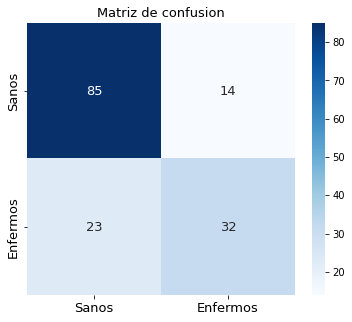

In [ ]:
matrix = consufion_matrix(y_test, y_pred,'Enfermos', 'Sanos')

El modelo para la detección de enfermos es muy regular, ya que tiene un porcentaje conciderable de falsos negativos, ya que se está detectando enfermos como sanos, esto puede explicar los malos resultados en la grafica de rendimiento con el recall.

In [ ]:
# Metricas
def metricas(validation: np.ndarray, prediction:np.ndarray, matrix:np.ndarray, label:list=[1])->None:
  print(f'Accuracy  :   {metrics.accuracy_score(validation, prediction)}')
  print(f'Kappa     :   {metrics.cohen_kappa_score(validation, prediction)}')
  print(f'predicción enfermos')
  print(f'Precision:   {metrics.precision_score(validation, prediction, labels=label, average="macro")}')
  print(f'Recall    :   {metrics.recall_score(validation, prediction, labels=label, average="macro")}')

  VN = matrix[0,0]
  FP = matrix[0,1]
  specificity = VN/(VN+FP)

  print(f'Specificity:   {specificity}')
  print(f'F1-score   :   {metrics.f1_score(validation, prediction, labels=label, average="macro")}' )

In [ ]:
metricas(y_test, y_pred, matrix)

Accuracy  :   0.7597402597402597
Kappa     :   0.4570230607966457
predicción enfermos
Precision:   0.6956521739130435
Recall    :   0.5818181818181818
Specificity:   0.8585858585858586
F1-score   :   0.6336633663366337


- El numero de predicciones correctas por el modelo es del 70%, pero el inconveniente es que los datos se encuentran desbalanceados

- La kappa me indica que el modelo tiene un ajuste de suerte del 35%, lo que indica que aproximadamente el 55% de las predicciones fueron realizadas por suerte

- Una sensibilidad pesima del 58% para realizar predicciones con respecto a todos los casos de diabetes reales

# **PRECISION-RECALL**
---

In [ ]:
y_prob = model.predict(X_test)
pos_prob = np.reshape(y_prob, y_prob.shape[0])

In [ ]:
def precision_recall(y:np.ndarray, prediction_prob:np.ndarray, validation:np.ndarray)->float:
  no_skill = len(y[y==1]) / len(y)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
  precision, recall, _ = metrics.precision_recall_curve(validation, prediction_prob)
  plt.plot(recall, precision, marker='.', label='Multi Layer Perceptron')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  auc_score = metrics.auc(recall, precision)
  plt.show()
  return auc_score

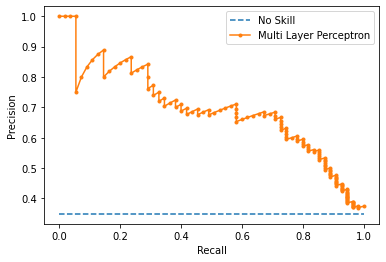

In [ ]:
auc_score = precision_recall(y, pos_prob, y_test)

In [ ]:
print('Multi Layer Perceptron PR AUC: %.3f' % auc_score)

Multi Layer Perceptron PR AUC: 0.693


- El modelo tiene un habilidad por encima del promedio (Modelo sin habilidad)
- Es posible que con más datos y una estructura más amplia el modelo pueda mejorar su capacidad de predicción para detectar pacientes con diabetes.